# Rekko challenge 2019

```
                           /$$$$$$$  /$$$$$$$$ /$$   /$$ /$$   /$$  /$$$$$$ 
                          | $$__  $$| $$_____/| $$  /$$/| $$  /$$/ /$$__  $$
                          | $$  \ $$| $$      | $$ /$$/ | $$ /$$/ | $$  \ $$
                          | $$$$$$$/| $$$$$   | $$$$$/  | $$$$$/  | $$  | $$
                          | $$__  $$| $$__/   | $$  $$  | $$  $$  | $$  | $$
                          | $$  \ $$| $$      | $$\  $$ | $$\  $$ | $$  | $$
                          | $$  | $$| $$$$$$$$| $$ \  $$| $$ \  $$|  $$$$$$/
                          |__/  |__/|________/|__/  \__/|__/  \__/ \______/ 
                                                                            
```

Добро пожаловать на соревнование по машинному обучению от онлайн-кинотеатра [Okko](http://okko.tv) Rekko Challenge 2019.

В этом ноутбуке мы покажем вам пример простого но полного решения, от загрузки данных до формирования ответа. Для работы нам понадобятся библиотеки `pandas`, `numpy`, `scipy`, `implicit`, `pprint`, `tqdm`. Установить их в вашем рабочем окружении можно следующей командой.
```
pip install pandas numpy scipy implicit pprint tqdm
```

In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp
from implicit.nearest_neighbours import TFIDFRecommender, CosineRecommender
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


%matplotlib inline
from pprint import pprint

### Загрузка данных

Замените `DATA_PATH` на путь к данным, которые вы скачали со страницы соревнования.

In [2]:
DATA_PATH = './'

---

`catalogue.json` содержит анонимизированную метаинформацию о доступных в сервисе фильмах и сериалах.

In [3]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)
    
catalogue = {int(k): v for k, v in catalogue.items()}

In [4]:
df_catal = pd.DataFrame(catalogue).transpose()

In [1]:
df_catal.head()

NameError: name 'df_catal' is not defined

In [5]:
for i in df_catal.columns.tolist():
    if type(df_catal[i][0]) == np.int32:
        df_catal[i] = df_catal[i].astype(int)
    if type(df_catal[i][0]) == np.float64:
        df_catal[i] = df_catal[i].astype(float)

In [6]:
df_catal.describe()

TypeError: unhashable type: 'list'

C:\Users\nord2\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2736

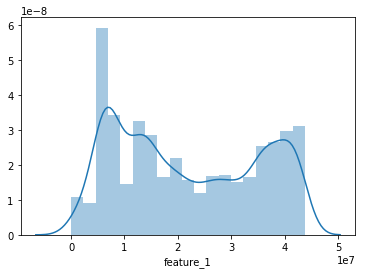

In [41]:
sns.distplot(df_catal['feature_1'].astype(float))
df_catal['feature_1'].astype(float).describe()
df_catal['feature_1'].astype(float).nunique()
#np.quantile(df_catal['feature_1'].astype(float), .1)

C:\Users\nord2\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count    10200.000000
mean         0.717518
std          0.055742
min          0.265899
25%          0.692949
50%          0.727813
75%          0.757026
max          0.827014
Name: feature_2, dtype: float64

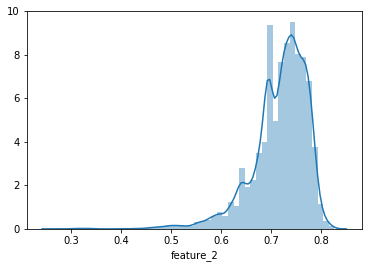

In [86]:
sns.distplot(df_catal['feature_2'].astype(float))
# df_catal['feature_2'].astype(float).nunique()
df_catal['feature_2'].astype(float).describe()
# df_feature = df_catal['feature_2'].astype(float).sort_values().head(100)

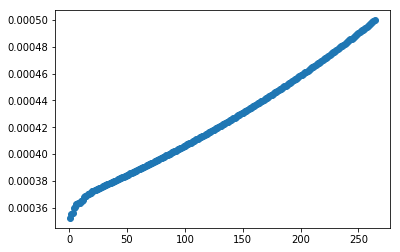

In [85]:
df_feature = pd.DataFrame(df_catal['feature_2'].astype(float).sort_values().drop_duplicates().reset_index())
diffs = df_feature.diff().fillna(0).astype(float).sort_values(by = 'feature_2').reset_index()
plt.plot(diffs.query('(feature_2 < 0.0005) & (feature_2 > 0.0003)').sort_values(by = 'feature_2')['feature_2'], 'o')
# diffs.head(100)
# diffs.query('feature_2 < 0.01').sort_values(by = 'feature_2')

In [88]:
(0.827014 - 0.732851)/0.000360/12

21.79699074074074

C:\Users\nord2\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count    10200.000000
mean         8.096176
std          6.603299
min          0.000000
25%          3.000000
50%          8.000000
75%         11.000000
max         50.000000
Name: feature_3, dtype: float64

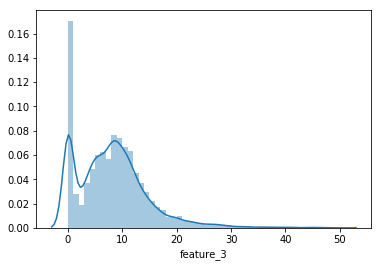

In [48]:
sns.distplot(df_catal['feature_3'].astype(float))
# df_catal['feature_3'].astype(float).nunique()
df_catal['feature_3'].astype(float).describe()

C:\Users\nord2\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count    10200.000000
mean         1.115200
std          0.036055
min          0.734394
25%          1.113885
50%          1.126575
75%          1.135231
max          1.141929
Name: feature_4, dtype: float64

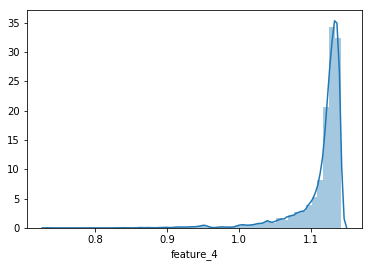

In [39]:
sns.distplot(df_catal['feature_4'].astype(float))
df_catal['feature_4'].astype(float).describe()

In [95]:
df_catal.query('duration > 200').sort_values(by = 'feature_2').head(100)

,element_uid,attributes,availability,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type
3152,3152,"[3843, 3835, 3844, 2538, 2278, 7, 3845, 31, 32...","[purchase, rent]",290,4.10461e+07,0.732851,20,1.14027,0.654707,movie
9932,9932,"[3862, 3099, 3863, 3864, 3123, 7, 522, 31, 32,...","[purchase, rent]",220,4.36338e+07,0.740055,26,1.14193,0.592716,movie
2256,2256,"[16527, 22238, 559, 13201, 2518, 192, 7, 22239...","[purchase, rent]",220,3.14465e+07,0.762089,20,1.1386,0.68041,movie
9511,9511,"[2320, 144, 3688, 3689, 771, 7, 52, 774, 42, 5...","[purchase, rent]",230,1.20534e+07,0.767494,2,1.10242,0.654707,movie
5616,5616,"[677, 613, 697, 216, 127, 7, 8631, 8632, 31, 3...","[purchase, rent]",210,4.30461e+07,0.779663,28,1.14193,0.654707,movie
1127,1127,"[6828, 3850, 6843, 10380, 11080, 52, 6830, 130...","[purchase, rent]",210,1.2739e+07,0.783234,11,1.02389,0,movie
6720,6720,"[1625, 5132, 8617, 11855, 1395, 113, 7, 9960, ...",[],220,6.40055e+06,0.793353,0,1.07764,0.654707,movie
10100,10100,"[6812, 6813, 6814, 6815, 6816, 7, 6817, 6818, ...","[purchase, subscription]",210,6.37257e+06,0.797549,17,0.949953,0.592716,movie


C:\Users\nord2\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


6

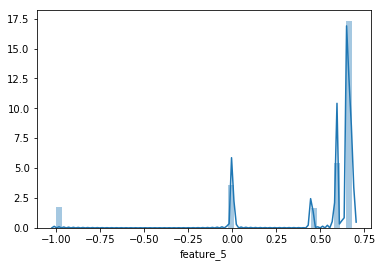

In [49]:
sns.distplot(df_catal['feature_5'].astype(float))
df_catal['feature_5'].astype(float).nunique()
# df_catal['feature_5'].astype(float).describe()

In [8]:
df_catal = df_catal.reset_index().rename(columns={'index': 'element_uid'})

 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

---

`test_users.json` содержит список пользователей, для которых необходимо построить предсказание

In [10]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

In [11]:
len(test_users)

50000

---

`transactions.csv` — список всех транзакций за определённый период времени

In [12]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

Wall time: 7.7 s


 - `element_uid` — идентификатор элемента
 - `user_uid` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

`ratings.csv` содержит информацию о поставленных пользователями оценках

In [13]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

Wall time: 263 ms


 - `rating` — поставленный пользователем рейтинг (от `0` до `10`)

`bookmarks.csv` содержит информацию об элементах, добавленных пользователями в список «Избранное»

In [14]:
%%time
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

Wall time: 493 ms


### Формирование целевой переменной

In [15]:
df_catal.head()

,element_uid,attributes,availability,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type
0,0,"[31115, 6713, 10906, 31116, 31117, 270, 24431,...",[],80,2.9122e+07,0.57526,0,1.12833,0.654707,movie
1,1,"[2786, 385, 2799, 3730, 886, 7, 11700, 42, 20,...","[purchase, rent]",120,6.61043e+06,0.773224,3,1.11201,0.654707,movie
2,2,"[31442, 31443, 31444, 31445, 113, 31446, 42, 3...",[],80,1.31587e+07,0.699502,0,1.11013,0.68041,movie
3,3,"[34361, 34362, 23033, 14887, 270, 20089, 43, 25]",[],20,4.15771e+07,0.702981,0,1.14193,0.654707,series
4,4,"[26732, 26733, 26734, 9367, 7792, 336, 26735, ...","[purchase, rent, subscription]",70,3.99958e+07,0.626596,8,1.13008,0.592716,movie


In [16]:
df_all = pd.merge(transactions, df_catal, how='left', on='element_uid')

In [17]:
element_agg = df_all.groupby('element_uid').agg({'watched_time': ['mean', 'median']})
element_agg.columns = ['elem_watched_time_mean', 'elem_watched_time_median']
element_agg.reset_index(inplace=True)
df_all = pd.merge(df_all, element_agg, how='left', on='element_uid')

In [18]:
def func_target(x):
    if ((x[0] in set(['series', 'multipart_movie'])) and (x[1] in set(['P', 'R']) or x[1] == 'S' and x[3] > x[4]/3)) or\
    ((x[0] == 'movie') and ((x[1] in set(['P', 'R']) or x[1] == 'S' and x[3] > x[2]*60/2))):
        return 1
    else:
        return 0

In [19]:
%%time
df_all['target'] = df_all[['type', 'consumption_mode', 'duration', 'watched_time', 'elem_watched_time_median']].apply(func_target, axis=1)

Wall time: 9min 12s


In [20]:
df_all['target'].sum()

6558159

In [ ]:
transactions['tmp_target'] = df_all['target']

### Формирование признаков для пользователя

Исследование распределений пользователей и элементов

Пользователей с 50+ фильмами: 44996
Пользователей из тестовой выборки с 50+ фильмами: 7756
Фильмов с 1000+ просмотров: 1706
Итоговый размер датасета для классификации: 63531440
Кол-во в датасете элементов класса 1: 2626503
Доля элементов класса 1: 4.1%


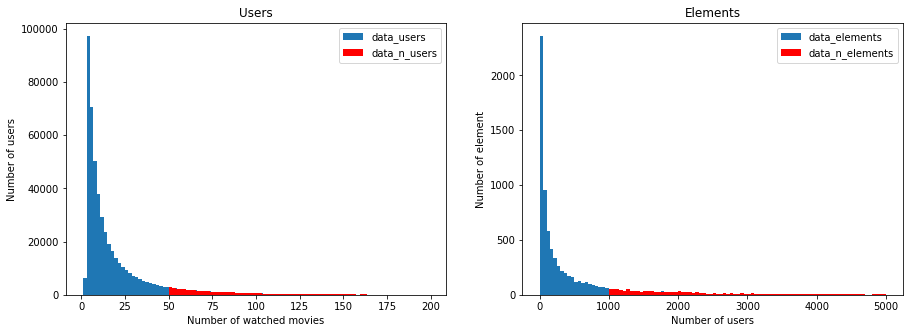

In [21]:
n_films = 50
data_users = pd.DataFrame(transactions.groupby('user_uid')['element_uid'].count()).sort_values('element_uid', ascending=False)
data_n_users = data_users[data_users['element_uid'] >= n_films]
print('Пользователей с {}+ фильмами: {}'.format(n_films, data_n_users.shape[0]))
n_test_users = sum(data_users.reset_index()[data_users.reset_index()['user_uid'].apply(lambda x: x in test_users)]['element_uid'] >= n_films)
print('Пользователей из тестовой выборки с {}+ фильмами: {}'.format(n_films, n_test_users))

n_users = 1000
data_films = pd.DataFrame(transactions.groupby('element_uid')['user_uid'].count()).sort_values('user_uid', ascending=False)
data_n_films = data_films[data_films['user_uid'] >= n_users]
print('Фильмов с {}+ просмотров: {}'.format(n_users, data_n_films.shape[0]))

shape0 = sum(data_films['user_uid'] >= n_users)*(sum(data_users['element_uid'] >= n_films)-n_test_users)
print('Итоговый размер датасета для классификации: {}'.format(shape0))

class1 = sum((transactions['user_uid'].isin(data_n_users.index.tolist())) & (transactions['element_uid'].isin(data_n_films.index.tolist()))\
                                                             & ~(transactions['user_uid'].isin(test_users)))
print('Кол-во в датасете элементов класса 1: {}'.format(class1))
print('Доля элементов класса 1: {}%'.format(round(class1/shape0*100, 1)))


# Гистограммы пользователей и элементов
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(data_users[data_users['element_uid']<200]['element_uid'].tolist(), bins=100)
axes[0].hist(data_users[(data_users['element_uid']<200)&(data_users['element_uid']>=50)]['element_uid'].tolist(), color='red', bins=75)
axes[0].set_ylabel('Number of users');
axes[0].set_xlabel('Number of watched movies');
axes[0].title.set_text('Users');
axes[0].legend(['data_users','data_n_users']);

axes[1].hist(data_films[data_films['user_uid']<5000]['user_uid'].tolist(), bins=100)
axes[1].hist(data_films[(data_films['user_uid']<5000)&(data_films['user_uid']>=1000)]['user_uid'].tolist(), color='red', bins=80);
axes[1].set_ylabel('Number of element');
axes[1].set_xlabel('Number of users');
axes[1].title.set_text('Elements');
axes[1].legend(['data_elements','data_n_elements']);


In [22]:
data_tr = pd.DataFrame(data=df_all.groupby('user_uid')['element_uid'].count()).reset_index().rename(columns={'element_uid': 'count_trx'})

In [23]:
def get_new_columns(name, aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

def feat_group(df, col_group, aggs, data, column=None):
    if column==None:
        d = df.groupby([col_group]).agg(aggs)
        cols = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
        d.columns = cols
        d.reset_index(drop=False,inplace=True)
        data = pd.merge(data, d, on=col_group, how='left')
    else:
        for c in df[column].unique():
            d = df[df[column]==c].groupby([col_group, column]).agg(aggs)
            cols = [c + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
            d.columns = cols
            d.reset_index(drop=False,inplace=True)
            d.drop(column, axis=1, inplace=True)
            data = pd.merge(data, d, on=col_group, how='left')
            
    return data

In [24]:
df_all['duration'] = df_all['duration'].astype(int)
for col in ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']:
    df_all[col] = df_all['duration'].astype(float)

df_all['diff_ts'] = -df_all.groupby('user_uid')['ts'].diff().fillna(0).astype(int)

In [25]:
aggs1 = {'watched_time': ['mean', 'sum'],
        'duration': ['mean', 'sum', 'std', 'min', 'max']
       }
data_tr = feat_group(df_all, col_group='user_uid', aggs = aggs1, data=data_tr, column='consumption_mode')
data_tr = feat_group(df_all, col_group='user_uid', aggs = aggs1, data=data_tr, column='type')

In [26]:
aggs2 = {'ts': ['max', 'min'],
         'diff_ts': ['mean', 'std', 'max'],
         'duration': ['mean', 'max', 'min'],
         'device_type': ['nunique'],
         'device_manufacturer': ['nunique'],
         'feature_1': ['nunique', 'mean'],
         'feature_2': ['mean'],
         'feature_3': ['mean'],
         'feature_4': ['mean'],
         'feature_5': ['mean']
        }
data_tr = feat_group(df_all, col_group='user_uid', aggs = aggs2, data=data_tr, column=None)

In [ ]:
ratings['diff_ts'] = -ratings.groupby('user_uid')['ts'].diff().fillna(0).astype(int)

In [ ]:
agg_r = {'ts': ['max', 'min'],
         'diff_ts': ['mean', 'std', 'max'],
         'rating': ['mean', 'max', 'min', 'std', 'nunique']
         }
d = ratings.groupby('user_uid').agg(agg_r)
d.columns = get_new_columns('rate', agg_r)
d.reset_index(drop=False,inplace=True)
#d['user_uid'] = d['user_uid'].astype('O')
d['rate_count'] = ratings.groupby('user_uid')['element_uid'].count()
data_tr = pd.merge(data_tr, d, on='user_uid', how='left')

In [ ]:
data_tr.head()

In [ ]:
bookmarks['diff_ts'] = -bookmarks.groupby('user_uid')['ts'].diff().fillna(0).astype(int)

In [ ]:
agg_bm = {'ts': ['max', 'min'],
         'diff_ts': ['mean', 'std', 'max'],
         }
d = bookmarks.groupby('user_uid').agg(agg_bm)
d.columns = get_new_columns('book', agg_bm)
d.reset_index(drop=False,inplace=True)
#d['user_uid'] = d['user_uid'].astype('O')
d['book_count'] = bookmarks.groupby('user_uid')['element_uid'].count()
data_tr = pd.merge(data_tr, d, on='user_uid', how='left')

In [ ]:
data_tr.head()

### Формирование признаков для элементов

In [ ]:
df_catal.head()

## Модель

In [ ]:
transactions_new = transactions[transactions['tmp_target']==1]
transactions_new['user_uid'] = transactions_new['user_uid'].astype('category')
transactions_new['element_uid'] = transactions_new['element_uid'].astype('category')

transactions_matrix = sp.coo_matrix(
    (transactions_new['tmp_target'].astype(np.float32) + 1,
        (
            transactions_new['element_uid'].cat.codes.copy(),
            transactions_new['user_uid'].cat.codes.copy()
        )
    )
)

transactions_matrix = transactions_matrix.tocsr()

In [ ]:
model2 = TFIDFRecommender()
model2.fit(transactions_matrix)

In [ ]:
transactions_matrix_T = transactions_matrix.T.tocsr()

In [ ]:
user_uid_to_cat2 = dict(zip(
    transactions_new['user_uid'].cat.categories,
    range(len(transactions_new['user_uid'].cat.categories))
))

In [ ]:
element_uid_to_cat2 = dict(zip(
    transactions_new['element_uid'].cat.categories,
    range(len(transactions_new['element_uid'].cat.categories))
))

In [ ]:
filtered_elements_cat2 = {k: [element_uid_to_cat2.get(x, None) for x in v] for k, v in filtered_elements.items()}

In [ ]:
result2 = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat2[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recs = model2.recommend(
        user_cat,
        transactions_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat2.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    result2[user_uid] = [int(transactions_new['element_uid'].cat.categories[i]) for i, _ in recs]

In [ ]:
with open('my_answer_new_target3.json', 'w') as f:
    json.dump(result2, f)

In [ ]:
import itertools
somelists = [[1, 2, 3], [51, 52]]
a = itertools.product(*somelists)
pd.DataFrame({'u': [i[0] for i in itertools.product(*somelists)],
'e': [i[1] for i in itertools.product(*somelists)]})

In [ ]:
#matplotlib.rcParams['figure.figsize'] = (20, 20)
#sns.heatmap(data_tr.corr(), cmap="YlGnBu");

### Решение

Для начала построим список элементов, которые тестовые пользователи уже купили или посмотрели по подписке: они не смогут купить их второй раз, а просмотр по подписке второй раз маловероятен, поэтому мы захотим отфильтровать такие элементы из финального ответа.

Точно так же можно поступить и с рейтингами и добавлениями в избранное, если это будет казаться правильным.

In [ ]:
from collections import defaultdict

filtered_elements = defaultdict(set)

for user_uid, element_uid in tqdm.tqdm(transactions.loc[:, ['user_uid', 'element_uid']].values):
    if user_uid not in test_users:
        continue
    filtered_elements[user_uid].add(element_uid)

In [ ]:
#for element_uid in tqdm.tqdm(df_catal[df_catal['availability'].apply(lambda x: len(x))==0]['element_uid'].values.tolist()):
    #for user_uid in test_users:
        #filtered_elements[user_uid].add(element_uid)

---

Для примера мы воспользуемся методом K ближайших соседей, реализованным в библиотеке `implicit`. В качестве данных используем только информацию о рейтингах.

Необходимо построить разреженную матрицу, где строкам будут соответствовать элементы, столбцам — пользователи, а на пересечении пользователя и элемента будет находиться количественная оценка степени их взаимодействия, если таковое имело место.

Не забудем добавить `1` к рейтингу, чтобы избежать деления на ноль во время вычисления `tf-idf`.

In [ ]:
ratings['user_uid'] = ratings['user_uid'].astype('category')
ratings['element_uid'] = ratings['element_uid'].astype('category')

ratings_matrix = sp.coo_matrix(
    (ratings['rating'].astype(np.float32) + 1,
        (
            ratings['element_uid'].cat.codes.copy(),
            ratings['user_uid'].cat.codes.copy()
        )
    )
)

ratings_matrix = ratings_matrix.tocsr()

In [ ]:
sparsity = ratings_matrix.nnz / (ratings_matrix.shape[0] * ratings_matrix.shape[1])
print('Sparsity: %.6f' % sparsity)

Обучить модель крайне просто.

In [ ]:
from implicit.nearest_neighbours import TFIDFRecommender

model = TFIDFRecommender()
model.fit(ratings_matrix)

In [ ]:
ratings_matrix_T = ratings_matrix.T.tocsr()

Отображения из оригинальной категории во внутреннюю пригодится нам в дальнейшем.

In [ ]:
user_uid_to_cat = dict(zip(
    ratings['user_uid'].cat.categories,
    range(len(ratings['user_uid'].cat.categories))
))

In [ ]:
element_uid_to_cat = dict(zip(
    ratings['element_uid'].cat.categories,
    range(len(ratings['element_uid'].cat.categories))
))

In [ ]:
filtered_elements_cat = {k: [element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

---

В метод `model.recommend` мы передаём идентификатор пользователя, который получаем обратным преобразованием из категории, транспонированную матрицу взаимодействий, число необходимых рекомендаций и список элементов, которые мы договорились фильтровать из ответа.

Возвращает метод список пар (`element_cat`, `score`), отсортированный по вторым элементам. Из него необходимо достать все первые элементы пар и из категории преобразовать их к `element_uid`.

**Важно:** Не все тестовые пользователи есть в `ratings.csv` и не все из них есть в `transactions.csv`. Используя только один источник данных мы не можем построить полное предсказание. Такой ответ с неполным числом пользователей будет принят системой, но при вычислении средней метрики метрика для отсутствующих пользователей будет принята равной нулю.

In [ ]:
result = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recs = model.recommend(
        user_cat,
        ratings_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    result[user_uid] = [int(ratings['element_uid'].cat.categories[i]) for i, _ in recs]

In [ ]:
len(result)

Используя только информацию о рейтингах мы смогли построить предсказание для `16784` из `50000` тестовых пользователей. Ровно в таком виде ответы и стоит сохранить для отправки.

In [ ]:
with open('answer.json', 'w') as f:
    json.dump(result, f)

In [ ]:
result3 = result2
for i in result2.keys():
    if i in set(result.keys()):
        result3[i] = result[i]

In [ ]:
with open('my_answer_txn+rat.json', 'w') as f:
    json.dump(result3, f)

### Идеи
1. Генерировать негативные примеры равномерно или пропорционально популярности